In [1]:
!pip install pyldavis
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
import numpy as np
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger') # for POS_tag
nltk.download('maxent_ne_chunker') # for NER
nltk.download('words') # for NER
nltk.download('omw-1.4')
import gensim

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/jovyan/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 t

In [2]:
reviews = pd.read_csv('./data/Datafiniti_Hotel_Reviews_Jun19.csv', encoding='latin-1')

reviews = reviews[["reviews.text"]]
reviews = reviews.dropna()
reviews.head()

,reviews.text
0,"This hotel was nice and quiet. Did not know, t..."
1,We stayed in the king suite with the separatio...
2,"Parking was horrible, somebody ran into my ren..."
3,Not cheap but excellent location. Price is som...
4,If you get the room that they advertised on th...


In [3]:
def preprocessing(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]

    tokens = [nltk.stem.WordNetLemmatizer().lemmatize(token, pos='v') for token in tokens if len(token)>1]
    
    return tokens
reviews['reviews.text'] = list(map(preprocessing, reviews['reviews.text']))
print(reviews['reviews.text'])

0       [hotel, nice, quiet, know, train, track, near,...
1       [stay, king, suite, separation, bedroom, live,...
2       [park, horrible, somebody, run, rental, car, s...
3       [cheap, excellent, location, price, somewhat, ...
4       [get, room, advertise, website, pay, may, luck...
                              ...                        
2574    [great, hotel, decor, architecture, exceptiona...
2575    [arrive, lobby, beautiful, kimpton, allegro, b...
2576    [nice, boutique, hotel, usual, kimpton, style,...
2577    [always, consistent, always, take, great, care...
2578    [amaze, stay, kimpton, properties, staff, extr...
Name: reviews.text, Length: 2579, dtype: object


In [4]:
def to_string(text):
    text = ' '.join(map(str, text))

    return text
reviews['reviews.text.string'] = list(map(to_string, reviews['reviews.text']))
print(reviews['reviews.text.string'])

0       hotel nice quiet know train track near train p...
1       stay king suite separation bedroom live space ...
2       park horrible somebody run rental car stay n't...
3       cheap excellent location price somewhat standa...
4       get room advertise website pay may lucky.if st...
                              ...                        
2574    great hotel decor architecture exceptional mix...
2575    arrive lobby beautiful kimpton allegro busy sa...
2576    nice boutique hotel usual kimpton style hotel ...
2577    always consistent always take great care us fa...
2578    amaze stay kimpton properties staff extremely ...
Name: reviews.text.string, Length: 2579, dtype: object


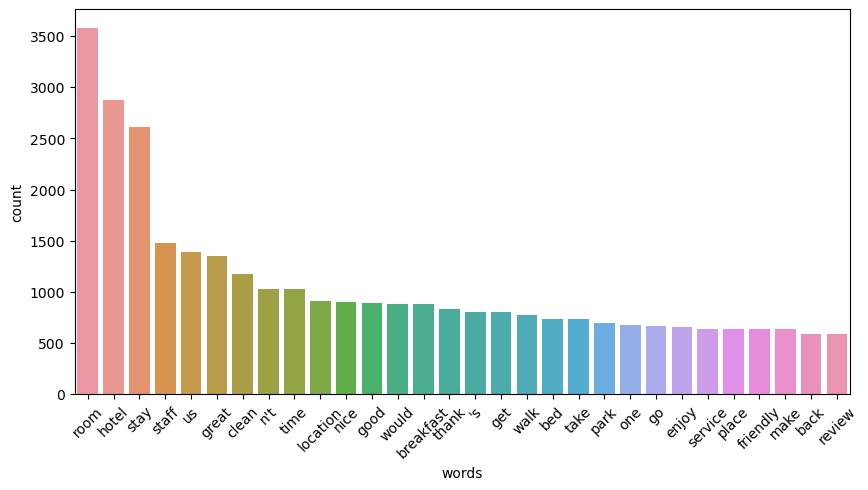

In [5]:
from collections import Counter

review_words = ','.join(list(reviews['reviews.text.string'].values))
Counter = Counter(review_words.split())
most_frequent = Counter.most_common(30)
fig = plt.figure(1, figsize = (10,5))
data = pd.DataFrame(most_frequent, columns=("words","count"))
sns.barplot(x = 'words', y = 'count', data = data)
plt.xticks(rotation=45);

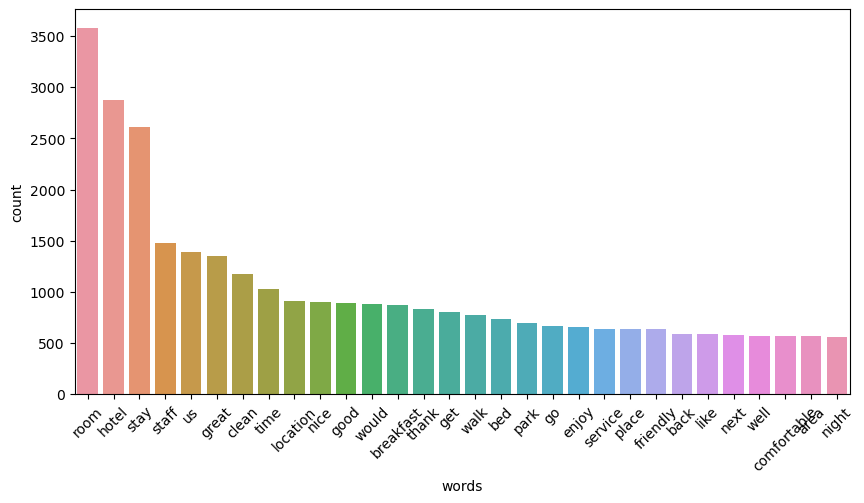

In [6]:
from collections import Counter
stopwords_list = ['make', 'take', 'one', 'review', "'s", "n't"]
reviews['reviews.text'] = [[word for word in line if word not in stopwords_list] for line in reviews['reviews.text']]
reviews['reviews.text.string'] = list(map(to_string, reviews['reviews.text']))

review_words = ','.join(list(reviews['reviews.text.string'].values))

Counter = Counter(review_words.split())
most_frequent = Counter.most_common(30)

fig = plt.figure(1, figsize = (10,5))
data = pd.DataFrame(most_frequent, columns=("words","count"))
sns.barplot(x = 'words', y = 'count', data = data)
plt.xticks(rotation=45);

OptionError: No such keys(s): 'mode.use_inf_as_null'

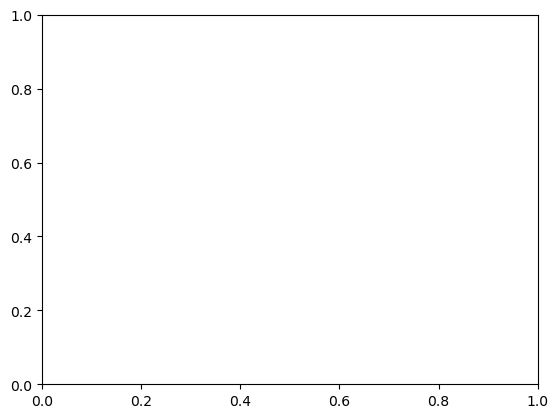

In [8]:
from gensim.models import CoherenceModel

wordId = gensim.corpora.Dictionary(reviews['reviews.text'])
something = [wordId.doc2bow(text) for text in reviews['reviews.text']]

number_of_topics = []
coherence_score = []
for i in range(1,10):
  model = gensim.models.ldamodel.LdaModel(corpus=something,
                                           id2word=wordId,
                                           iterations=50,
                                           num_topics=i)
  coherence_model = CoherenceModel(model=model, 
                                       texts=reviews['reviews.text'], 
                                       dictionary=wordId, 
                                       coherence='u_mass')
  coherence = coherence_model.get_coherence()
  number_of_topics.append(i)
  coherence_score.append(coherence)

topic_coherence = pd.DataFrame({'number_of_topics':number_of_topics,
                                'coherence_score':coherence_score})
sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score')

In [9]:
topics = 7

lda_model = gensim.models.ldamodel.LdaModel(corpus=something,
                                           id2word=wordId,
                                           num_topics=topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=5,
                                           passes=20,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} Word: {}".format(idx, topic))

Topic: 0 Word: 0.050*"well" + 0.033*"welcome" + 0.030*"inn" + 0.029*"even" + 0.028*"always" + 0.021*"never" + 0.020*"point" + 0.020*"help" + 0.017*"perfect" + 0.016*"keep"
Topic: 1 Word: 0.065*"room" + 0.030*"stay" + 0.020*"get" + 0.020*"location" + 0.018*"hotel" + 0.015*"breakfast" + 0.014*"desk" + 0.013*"service" + 0.013*"like" + 0.013*"front"
Topic: 2 Word: 0.040*"feel" + 0.034*"love" + 0.027*"floor" + 0.024*"tell" + 0.017*"would" + 0.017*"shower" + 0.017*"water" + 0.013*"husband" + 0.011*"disappoint" + 0.011*"extra"
Topic: 3 Word: 0.048*"experience" + 0.048*"us" + 0.043*"thank" + 0.028*"feedback" + 0.027*"manager" + 0.025*"forward" + 0.023*"please" + 0.022*"time" + 0.021*"staff" + 0.020*"guest"
Topic: 4 Word: 0.031*"call" + 0.029*"coffee" + 0.027*"try" + 0.024*"restaurant" + 0.021*"morning" + 0.021*"truly" + 0.014*"although" + 0.014*"anything" + 0.014*"charge" + 0.013*"use"
Topic: 5 Word: 0.060*"travel" + 0.045*"show" + 0.044*"book" + 0.040*"lot" + 0.029*"several" + 0.026*"size" + 

In [ ]:
import matplotlib.colors as mcolors
from wordcloud import WordCloud

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)
topics_ = lda_model.show_topics(formatted=False)
fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics_[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
                  